# TP2

This tutorial consists of two independent parts to illustrate the applications of Machine Learning in asset management:
* Linear regression model to predict the future performance of Amazon stock. (cf. CM3)
* Markowitz optimization problem with L2 regularization. (cf. CM4)

## Part I: Linear regression model to predict the future performance of Amazon stock 
This part involves building the linear regression model to predict the future performance of Amazon (NYSE) stock. Mathematically, we will build a linear model:
$$Y_{t, 10}=\sum_{k=1}^S \beta_t F_t^{(k)}+\epsilon_t, \quad \epsilon_t \sim N\left(0, \sigma_t^2\right)$$
$Y_{t, 10}$ denotes the return of the next 10 days to be predicted, and $F_{t}^{(k)}$ denotes $k$-th feature used in the linear predictive model.

### Preparation
First, we'll import the historical prices (close) of the Amazon stock and calculate the returns and moving averages as features of the linear model. 

C:\Users\Emile\AppData\Local\Temp\ipykernel_24008\1345588818.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


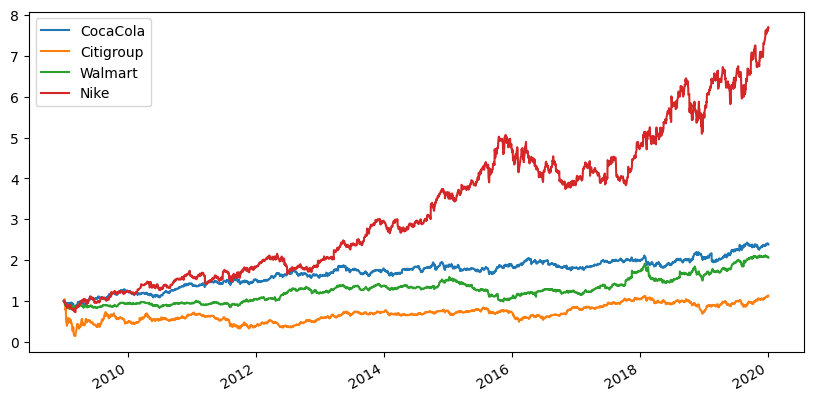

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# ---- Import data ----
stock_price = pd.read_csv(
    "TD2_MVO.csv",
    sep=";",
    index_col=0,
    parse_dates=True,
    dayfirst=True
)

stock_price.index.name = None

# ---- Plot historical prices ----
stock_price_normalised = stock_price / stock_price.iloc[0]
ax = stock_price_normalised.plot(figsize=(10, 5), linewidth=1.5, grid=False)

plt.show()

We will construct the explained and explanatory variables of our linear model: 
* The explained variable denotes the next 10-day return to be predicted.
* The explanatory variables are moving averages with different windows (1, 2, 4, 8, 16, 32, 64, 128) on daily returns. 

In [2]:
ticker = stock_price.columns[0]          # ou ticker = "AAPL"
price = stock_price[ticker]

daily_return = price.pct_change()
forward_return = price.shift(-10) / price - 1

Ftm_1   = daily_return
Ftm_2   = daily_return.rolling(2).mean()
Ftm_4   = daily_return.rolling(4).mean()
Ftm_8   = daily_return.rolling(8).mean()
Ftm_16  = daily_return.rolling(16).mean()
Ftm_32  = daily_return.rolling(32).mean()
Ftm_64  = daily_return.rolling(64).mean()
Ftm_128 = daily_return.rolling(128).mean()

all_data = pd.concat(
    [Ftm_1, Ftm_2, Ftm_4, Ftm_8, Ftm_16, Ftm_32, Ftm_64, Ftm_128, forward_return],
    axis=1
).dropna().head(300)

all_data.columns = ['Ftm1','Ftm2','Ftm4','Ftm8','Ftm16','Ftm32','Ftm64','Ftm128','forward_return']

features = all_data.drop(columns='forward_return')
label = all_data['forward_return']


**Q1: Correlation analysis** 

We're going to calculate the correlation coefficients between the explained variables and our feature vectors. What can you say about these correlations?

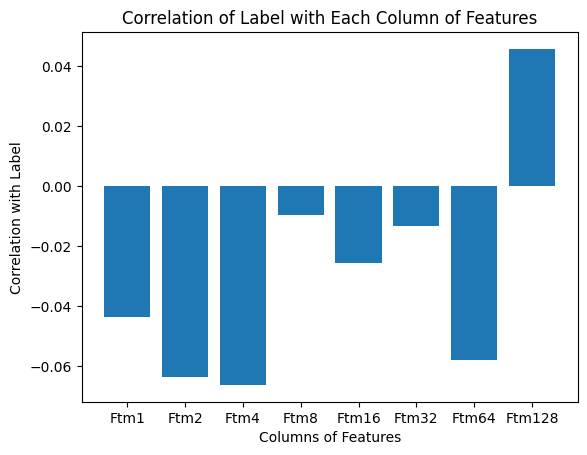

In [3]:
correlations = features.apply(lambda x: x.corr(label))

# Plotting the correlations using a bar plot
plt.bar(features.columns.to_list(), correlations)
plt.xlabel('Columns of Features')
plt.ylabel('Correlation with Label')
plt.title('Correlation of Label with Each Column of Features')
plt.show()

We can see that the dominant correlations are provided by $F_{tmK}$ with $ K\geq 8$. We can reasonably expect our model selection to choose most of the variables in this subset.

**Q2: Preprocessing**

Our regression model assumes a homoscedastic process. It is therefore necessary to standardize the explained variable and the feature vectors in the regression process. 

* For the explained variable $Y_{t, 10}$, a mean of zero is sufficient.
* For the feature vectors $F_{tmK}$, each factor needs to be standardized to have a mean of zero and a unit variance.

In [4]:
Yt = label.values
Ycen = Yt - np.mean(Yt)

# Standardizing the matrix Features
scaler = StandardScaler()
Mnorm = scaler.fit_transform(features)
Mnorm_df = pd.DataFrame(Mnorm, columns = features.columns)

**Q3: Linear regression**

We can now build a linear model using all the features and **sm.OLS()** function. What can you conclude from the model summary?

In [5]:
#### Ordinary least squares (OLS) regression #### 
X = sm.add_constant(Mnorm_df)  # Add constant for intercept
linModelFull = sm.OLS(Ycen, X).fit()

# Summary of the full model
print(linModelFull.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9883
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.445
Time:                        16:34:16   Log-Likelihood:                 646.99
No. Observations:                 300   AIC:                            -1276.
Df Residuals:                     291   BIC:                            -1243.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.318e-19      0.002   4.46e-16      1.0

**Q4: Backward method for variable selection**

We'll apply the Backward method for variable selection. At each stage, we remove the variable with the highest t-statistics p-value. Let's call this reduced model **linModelRed**. What can you conclude by comparing the selected features with the correlation analysis? How do we know that the reduced model preserves the same goodness of fit as the full model? (Hint: We can use **sm.stats.anova_lm** function to compare the two models).

In [6]:
#### Backward method for variable selection ####
print('Step 1')
linModelRed = sm.OLS(Ycen, X.drop(columns=['Ftm128'])).fit()
print(linModelRed.summary())
print('\n\n')

print('Step 2')
linModelRed = sm.OLS(Ycen, X.drop(columns=['Ftm128', 'Ftm64'])).fit()
print(linModelRed.summary())
print('\n\n')

#...#

# F-test: model comparison
print('Model comparison')
anova_results = sm.stats.anova_lm(linModelRed, linModelFull)
print(anova_results)
print('\n\n')

Step 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4650
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.859
Time:                        16:34:16   Log-Likelihood:                 644.63
No. Observations:                 300   AIC:                            -1273.
Df Residuals:                     292   BIC:                            -1244.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.318e-19      0.002   4.43e-16  

**Q5: Ridge and Lasso**

We can use the **sm.OLS().fit_regularized** function to perform ridge and lasso regressions. Read the document https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html and complete the following codes. Compare the two figures and interpret them.

Text(0, 0.5, 'Parameters')

<Figure size 640x480 with 0 Axes>

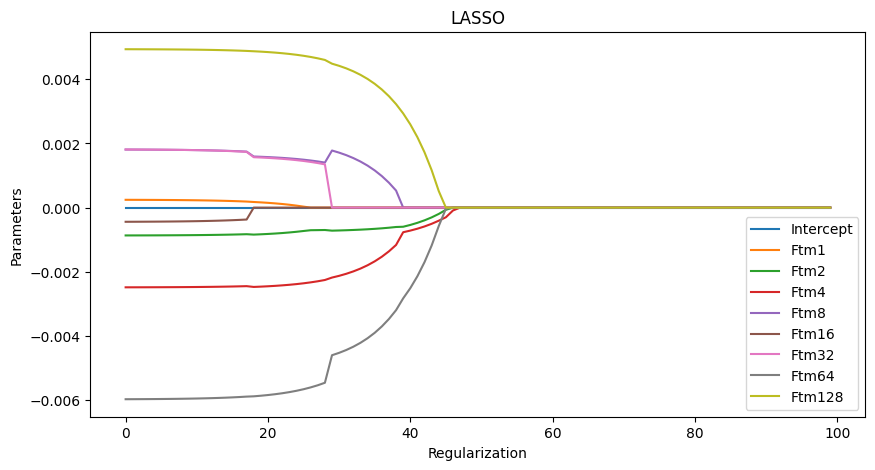

<Figure size 640x480 with 0 Axes>

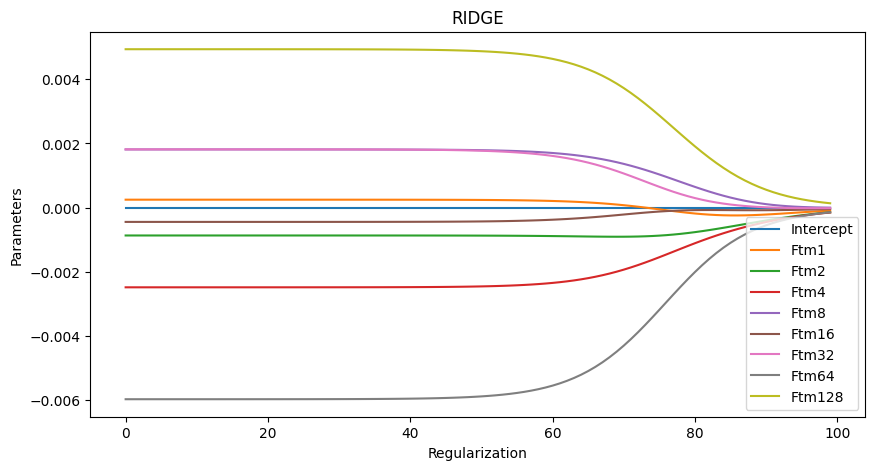

In [7]:
recap_lasso = list()
recap_ridge = list()
for ind_alpha in np.logspace(-6, 1, 100):
    X = sm.add_constant(Mnorm)
    lasso_result = sm.OLS(Ycen, X).fit_regularized(alpha=ind_alpha, L1_wt=1)
    ridge_result = sm.OLS(Ycen, X).fit_regularized(alpha=ind_alpha, L1_wt=0)
    recap_lasso.append(lasso_result.params)
    recap_ridge.append(ridge_result.params)

res_lasso = pd.DataFrame(recap_lasso, columns = ['Intercept', 'Ftm1', 'Ftm2', 'Ftm4', 'Ftm8', 'Ftm16', 'Ftm32', 'Ftm64', 'Ftm128'])
plt.figure()
res_lasso.plot(figsize = (10, 5), grid = False, linewidth = 1.5)
plt.title("LASSO")
plt.xlabel("Regularization")
plt.ylabel("Parameters")

res_ridge = pd.DataFrame(recap_ridge, columns = ['Intercept', 'Ftm1', 'Ftm2', 'Ftm4', 'Ftm8', 'Ftm16', 'Ftm32', 'Ftm64', 'Ftm128'])
plt.figure()
res_ridge.plot(figsize = (10, 5), grid = False, linewidth = 1.5)
plt.title("RIDGE")
plt.xlabel("Regularization")
plt.ylabel("Parameters")

## Part II: Markowitz optimization problem with L2 regularization

In this exercise, we'll use data from 4 US stocks (Coca Cola, Citi Group, Walmart, Nike) to illustrate the L2 regularization technique in portfolio optimization (Markowitz mean-variance optimization). 

We have a database with 2770 rows (number of observations) and 4 columns (number of companies).

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### Import data ####
stock_price = pd.read_csv("TD2_MVO.csv", index_col = [0], header = [0], sep = ";")
stock_price.index.name = None
stock_price.index = pd.to_datetime(stock_price.index, format = "%d/%m/%Y")

print(stock_price.shape)

(2770, 4)


<Axes: >

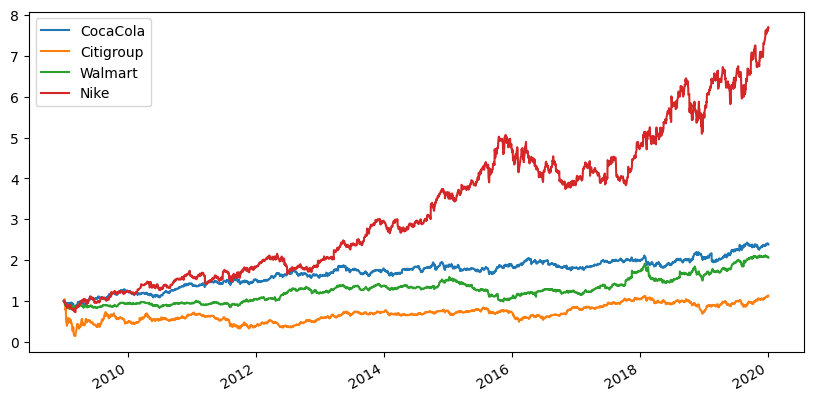

In [9]:
#### Plot historical prices ####
stock_price_normalised = stock_price/stock_price.iloc[0]
stock_price_normalised.plot(figsize = (10, 5), grid = False, linewidth = 1.5) 

### II.1/ Tracing the efficient frontier using the simulation method

The aim of this section is to generate 5,000 fictitious portfolios (random combinations of 4 stocks) to visualize the efficient frontier in Markowitz theory. 

We first calculate the compound annual growth rate (CGAR) and annual volatility for each asset with the functions in TD1.

In [10]:
# Function to compute Compound Annual Growth Rate (CAGR)
def compute_cagr(price, ann_multiple=252):
    n = len(price)
    cagr = (price.iloc[-1] / price.iloc[0]) ** (ann_multiple / n) - 1
    return cagr

# Function to compute Volatility
def compute_vol(price, ann_multiple=252):
    ret = price / price.shift(1) - 1  # Calculate returns
    n = len(price)  # Get the length of the time series
    mu = np.nanmean(ret)  # Calculate the mean
    sigma_daily = np.sqrt(np.nansum((ret - mu) ** 2) / (n - 1))  # Calculate daily volatility
    sigma = np.sqrt(ann_multiple) * sigma_daily  # Annualize the volatility
    return sigma

**Q1: Use the '.apply' and 'compute_cagr' functions to calculate the CAGR for each stock**

In [11]:
mus = stock_price.apply(compute_cagr)
mus = mus.values

**Q2: Calculate the returns for each stock, then calculate the (annual) covariance matrix using the 'cov' function**

In [12]:
stock_return = stock_price.pct_change().dropna()
Sigma = stock_return.cov() * 252
Sigma = Sigma.values

In the next section, we'll simulate the stock allocations to build the fictitious portfolios. To do this, we can simulate 4 numbers from 0 to 1 and then normalize them to sum to 100%. We simulate a total of 5,000 fictitious portfolios.


**Q3: Calculate the portfolio return and volatility of the fictitious portfolio using the @ operator (matrix product)**

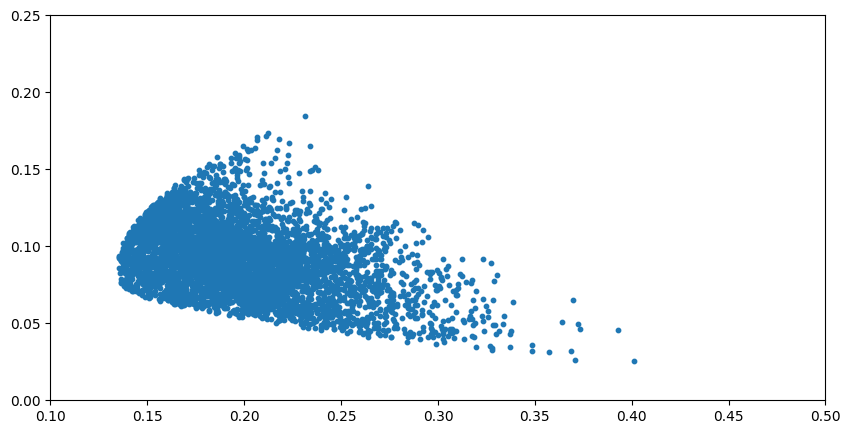

In [13]:
num_asset = stock_return.shape[1]
num_portfolios = 5000

recap_port_ret, recap_port_vol, recap_port_SR = list(), list(), list()
for ind in range(0, num_portfolios):
    weights = np.random.uniform(0, 1, num_asset)
    weights = weights/weights.sum()
    
    #### Q3: Calculate the portfolio return and volatility of the fictitious portfolio with the @ operator (matrix product) ####
    port_ret = weights @ mus
    port_vol = np.sqrt(weights.T @ Sigma @ weights)
    port_SR = port_ret / port_vol if port_vol > 0 else 0
  
    recap_port_ret.append(port_ret)
    recap_port_vol.append(port_vol)
    recap_port_SR.append(port_SR)
    
res_port_ret = pd.Series(recap_port_ret)
res_port_vol = pd.Series(recap_port_vol)
res_port_SR = pd.Series(recap_port_SR)

#### Tracer la frontiere efficiente ####
plt.figure(figsize = (10, 5))
plt.scatter(res_port_vol, res_port_ret, s = 10)
plt.xlim(0.1, 0.5)
plt.ylim(0, 0.25)
plt.show()

Each point represents a fictitious portfolio. The scatter plot therefore represents all possible combinations of the four stocks. The existence of the efficient frontier is clearly visible.

### II.2/ Plot the efficient frontier using quadratic programming

The aim of this section is to repeat the previous exercise and find the efficient frontier using quadratic programming.

We will use the $\gamma$-problem form of the Markowitz optimization problem (CM4) and recall that $\gamma$ is the trade-off coefficient between expected return and volatility.

**$\gamma$-problem**

$$w^{\star}(\gamma)=\arg \min \frac{1}{2} w^{T} \Sigma w-\gamma w^{T} \mu$$
$$\text{s.c.} \quad w^{T} \mathbf{1}= \sum_{i}w_{i} = 1 $$
$$ \quad  \quad  \quad w_{i} \geq 0, \forall i $$ 

$\gamma$-problem can be written in the form of quadratic programming (CM4). 

**Quadratic programming:**
$$\begin{array}{c}
w^{\star}=\arg \min \frac{1}{2} w^{T} Q w-w^{T} R \\
\text { s.c. } S w \leq T
\end{array}$$
with
$$Q=\Sigma \quad R=\gamma \mu$$
$$\begin{array}{lll}
\begin{array}{c} w^{T} \mathbf{1}=1 \\
 w_{i} \geq 0, \forall i \end{array} & \Leftrightarrow & \underbrace{\left[\begin{array}{c}
-(1, 1, ..., 1) \\
(1, 1, ..., 1) \\
-I_{n}
\end{array}\right]}_S w \leq \underbrace{\left[\begin{array}{c}
-1 \\
1 \\
\mathbf{0}_{n}
\end{array}\right]}_{T} & \Leftrightarrow \quad S w \leq T \\
\end{array}$$

We can use the 'solve_qp' function in the 'qpsolvers' package to perform quadratic programming in python. We need to read the 'solve_qp' function document carefully https://qpsolvers.github.io/qpsolvers/quadratic-programming.html and decide on the argument values: **P**, **q**, **A**, **b**, **G** and **h**. 

$$\begin{array}{c}
\min \frac{1}{2} w^{T} P w + w^{T} q  \\
\text { s.c. } G w \leq h \\
\quad  \quad  A w = b\end{array}$$

We'll solve the optimization problem in the form of quadratic programming for the different values of $\gamma$.

**Q4: Determine the arguments for quadratic programming and calculate the portfolio return and portfolio volatility with the @ operator.**

In [14]:
import sys
print(sys.executable)

c:\Users\Emile\AppData\Local\Programs\Python\Python312\python.exe


In [15]:
import sys
!"{sys.executable}" -m pip install -U pip
!"{sys.executable}" -m pip install -U qpsolvers osqp "qpsolvers[osqp]"

In [16]:
from qpsolvers import available_solvers
print(available_solvers)


['ecos', 'osqp']


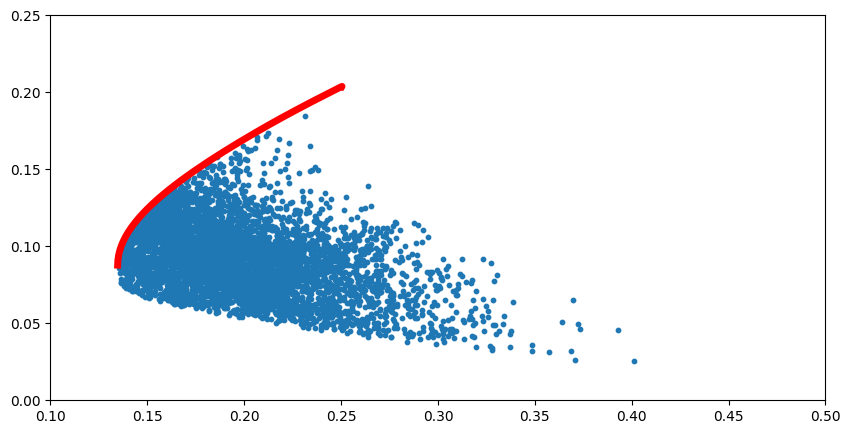

In [19]:
from qpsolvers import solve_qp
from qpsolvers import available_solvers

gammas = np.arange(0, 3.01, 0.01)
recap_port_ret_QP, recap_port_vol_QP, recap_port_SR_QP = list(), list(), list()

for ind_gamma in gammas:
    #### Q4: Determine arguments for quadratic programming  ####
    P = Sigma
    q = -ind_gamma * mus
    
    A = np.ones((1, num_asset))
    b = np.array([1.0])
        
    G = - np.eye(num_asset)
    h = np.zeros(num_asset)
  
    weights_QP = solve_qp(P, q, G, h, A, b, solver = "ecos")
  
    port_ret_QP = weights_QP @ mus
    port_vol_QP = np.sqrt(weights_QP.T @ Sigma @ weights_QP)
    port_SR_QP = port_ret_QP / port_vol_QP if port_vol_QP > 0 else 0
  
    recap_port_ret_QP.append(port_ret_QP)
    recap_port_vol_QP.append(port_vol_QP)
    recap_port_SR_QP.append(port_SR_QP)  


recap_port_ret_QP = pd.Series(recap_port_ret_QP)
res_port_vol_QP = pd.Series(recap_port_vol_QP)
res_port_SR_QP = pd.Series(recap_port_SR_QP)
  
#### Plot efficient frontier ####
plt.figure(figsize = (10, 5))
plt.scatter(res_port_vol, res_port_ret, s = 10)
plt.plot(res_port_vol_QP, recap_port_ret_QP, color = 'red', linewidth = 5)
plt.xlim(0.1, 0.5)
plt.ylim(0, 0.25)
plt.show()

We can see that the efficient frontier is well aligned with the point cloud.

### II.3/ Portfolio allocation over time

In this section, we set the value of $\gamma = 0.02$ and rebalance the portfolio every month. At each rebalancing date, we use one year of past data to estimate expected return and volatility.

**Q5: We need to use the answers to Q1$\sim$Q4 to fill in the blanks in the codes below.**

C:\Users\Emile\AppData\Local\Temp\ipykernel_24008\1144214694.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_rebalancement = stock_return['2010':].resample('M').last().index


<Figure size 640x480 with 0 Axes>

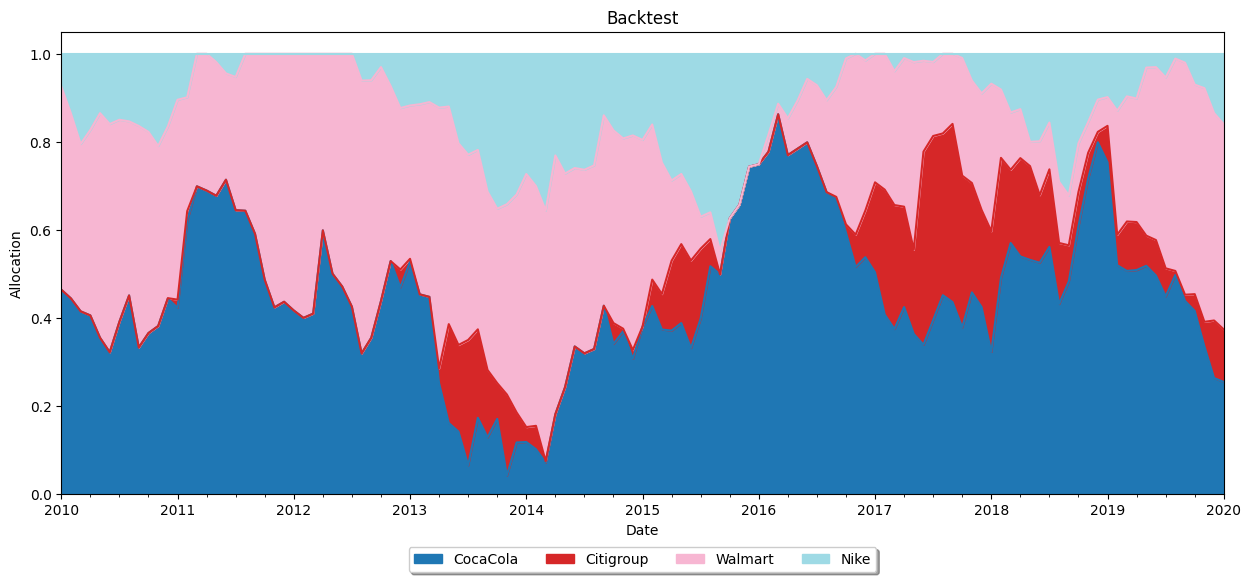

In [20]:
gamma = 0.02
num_observation = stock_return.shape[0]
index_rebalancement = stock_return['2010':].resample('M').last().index
weights_backtest = pd.DataFrame(index = index_rebalancement, columns = stock_return.columns)

for ind in index_rebalancement:
    price_tmp = stock_price[:ind].tail(252)
    return_tmp = price_tmp.pct_change().dropna()
      
    mus_tmp = price_tmp.apply(compute_cagr)
    mus_tmp = mus_tmp.values
    
    Sigma_tmp = return_tmp.cov() * 252
    Sigma_tmp = Sigma_tmp.values
        
    P = Sigma_tmp
    q = -gamma * mus_tmp
    
    A = np.ones((1, num_asset))
    b = np.array([1.0])
        
    G = - np.eye(num_asset)
    h = np.zeros(num_asset)
  
    weights_QP_tmp = solve_qp(P, q, G, h, A, b, solver = "ecos")
    weights_backtest.loc[ind] = weights_QP_tmp
    

plt.figure()
#### Plot portfolio allocation over time ####
weights_backtest.abs().plot(kind='area', stacked=True, cmap='tab20', figsize=(15, 6))
plt.title("Backtest")
plt.xlabel("Date")
plt.ylabel("Allocation")
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.1), fancybox = True, shadow = True, ncol = 4)

### II.4/ The L2 regularization technique

In this section, we'll look at the application of the L2 regularization technique. The aim is to solve the instability problem in Markowitz mean-variance optimization and reduce portfolio turnovers. We recall that the optimization problem ( $\gamma$-problem) with L2 regularization can be written as:

$$ \begin{array}{c}
w^{\star}=\arg \min \frac{1}{2} w^{T} \Sigma w-\gamma w^{T} \mu+\rho \left\|w-w_{old}\right\|_{2}^{2} \\
\text { s.c. } \quad w^{T} \mathbf{1}=1 \\
\quad  \quad  \quad  \quad w_{i} \geq 0, \forall i
\end{array}
$$

$w_{old}$ means the allocation of the previous rebalancing date.

We can also write the objective function of the above problem in quadratic programming form:
$$ \begin{array}{c}
w^{\star}=\arg \min \frac{1}{2} w^{T} \Sigma w-\gamma w^{T} \mu+\rho \left(w-w_{old}\right)^{T}\left(w-w_{old}\right) \\
\end{array}
$$

We can develop it:
$$\begin{array}{c}
w^{\star}=\arg \min \frac{1}{2} w^{T} \Sigma w-\gamma w^{T} \mu+\rho w^{T}w - 2\rho w^{T}w_{old} + \rho w_{old}^{T}w_{old}
\end{array}
$$

Since $\rho w_{old}^{T}w_{old}$ is a constant term, we can neglect it.

Finally, the quadratic programming version of the initial problem is:
$$ \begin{array}{c}
w^{\star}=\arg \min \frac{1}{2} w^{T}(\Sigma + 2\rho I_n) w- w^{T}( \gamma \mu + 2\rho w_{old})\\
\text { s.c. } \quad w^{T} \mathbf{1}=1 \\
\quad  \quad  \quad  \quad w_{i} \geq 0, \forall i
\end{array}
$$


**Q6: We can take the codes from Q5 and update the values of P, q to add the L2 regularization to the optimization. We can test different values of $\rho$ to see the impact of regularization**.

C:\Users\Emile\AppData\Local\Temp\ipykernel_24008\2688150273.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_rebalancement = stock_return['2010':].resample('M').last().index


<Figure size 640x480 with 0 Axes>

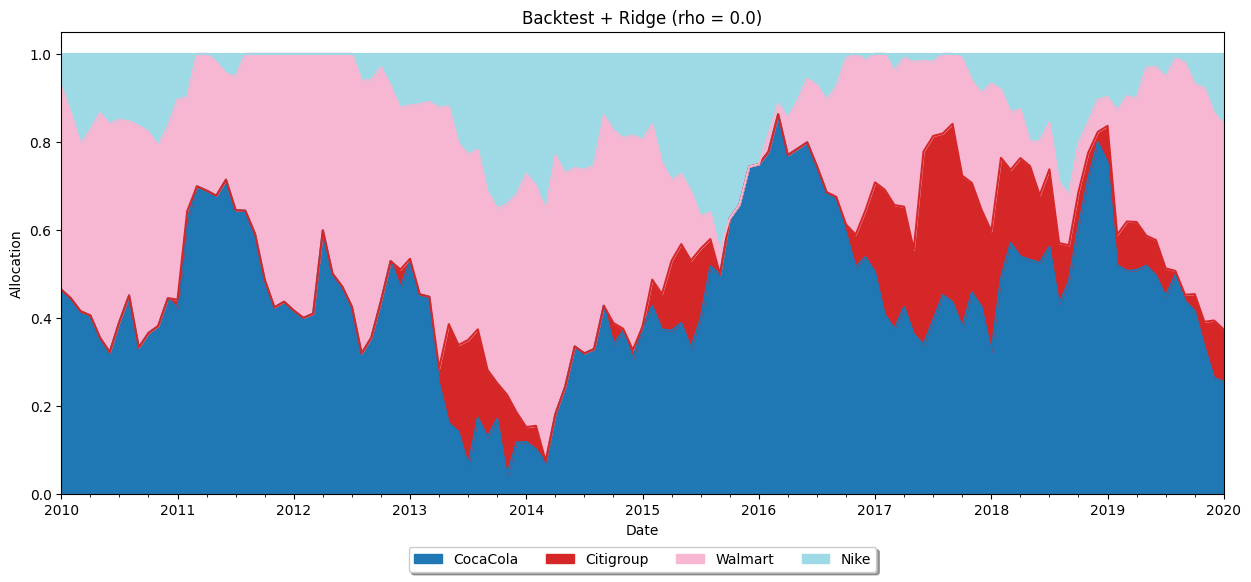

<Figure size 640x480 with 0 Axes>

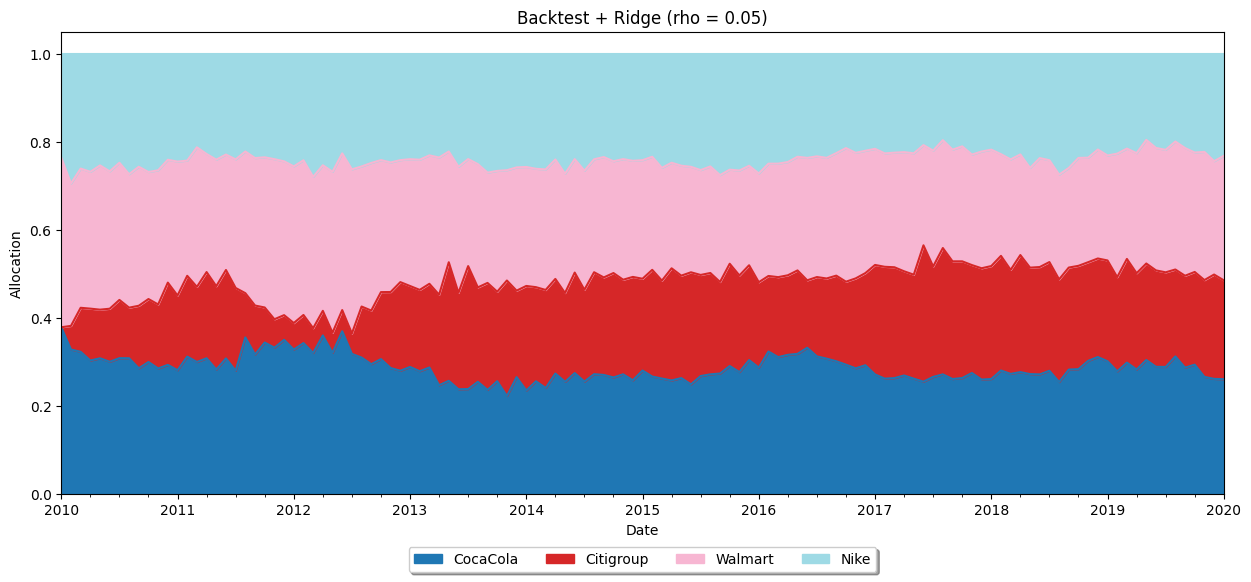

<Figure size 640x480 with 0 Axes>

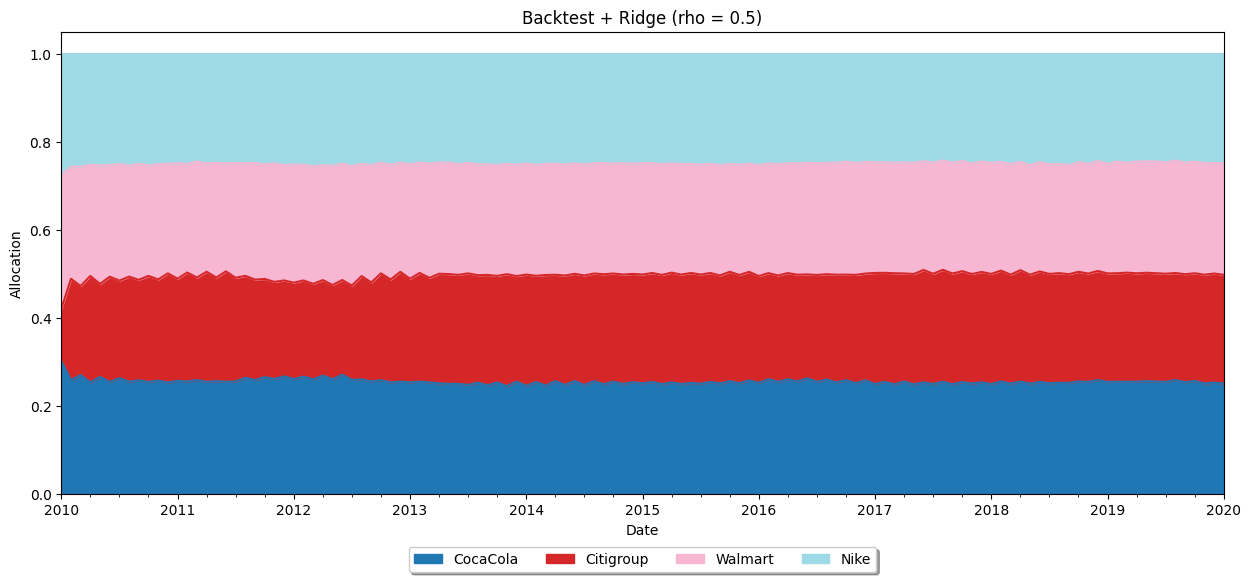

<Figure size 640x480 with 0 Axes>

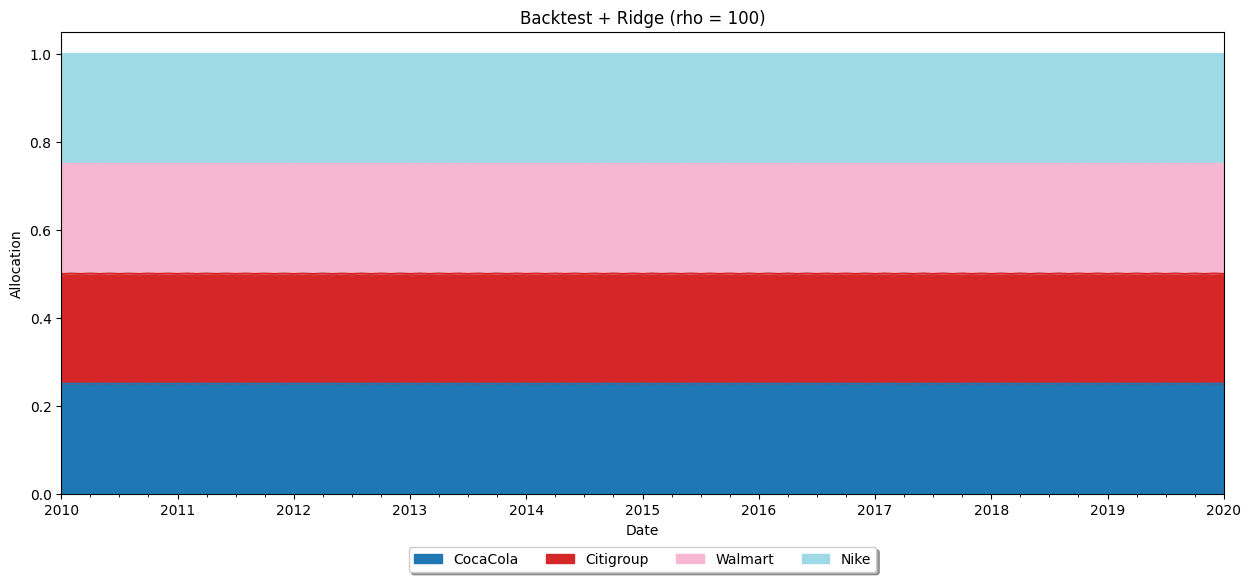

In [21]:
num_observation = stock_return.shape[0]
index_rebalancement = stock_return['2010':].resample('M').last().index

rhos = [0.0, 0.05, 0.5, 100]
for ind_rho in rhos:
    weights_backtest_2 = pd.DataFrame(index = index_rebalancement, columns = stock_return.columns)
    weights_old = np.array([0.25, 0.25, 0.25, 0.25])
    
    for ind in index_rebalancement:
        price_tmp = stock_price[:ind].tail(252)
        return_tmp = price_tmp.pct_change().dropna()
      
        mus_tmp = price_tmp.apply(compute_cagr)
        mus_tmp = mus_tmp.values
    
        Sigma_tmp = return_tmp.cov() * 252
        Sigma_tmp = Sigma_tmp.values
        
        P = Sigma_tmp + 2 * ind_rho * np.eye(num_asset)
        q = - gamma * mus_tmp + 2 * ind_rho * weights_old
    
        A = np.ones((1, num_asset))
        b = np.array([1.0])
        
        G = - np.eye(num_asset)
        h = np.zeros(num_asset)
  
        weights_ridge_tmp = solve_qp(P, q, G, h, A, b, solver = "ecos")
        weights_backtest_2.loc[ind] = weights_ridge_tmp
        weights_old = weights_ridge_tmp

    plt.figure()
    #### Plot portfolio allocation over time ####
    weights_backtest_2.abs().plot(kind='area', stacked=True, cmap='tab20', figsize=(15, 6))
    plt.title("Backtest + Ridge (rho = " + str(ind_rho) + ")")
    plt.xlabel("Date")
    plt.ylabel("Allocation")
    plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.1), fancybox = True, shadow = True, ncol = 4)